<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Linear-Layer" data-toc-modified-id="Linear-Layer-1">Linear Layer</a></span></li><li><span><a href="#Convolution-Layer" data-toc-modified-id="Convolution-Layer-2">Convolution Layer</a></span></li><li><span><a href="#Deconvolution-Layer" data-toc-modified-id="Deconvolution-Layer-3">Deconvolution Layer</a></span><ul class="toc-item"><li><span><a href="#Auto-Encoder" data-toc-modified-id="Auto-Encoder-3.1">Auto Encoder</a></span></li><li><span><a href="#Transposed-Convolution" data-toc-modified-id="Transposed-Convolution-3.2">Transposed Convolution</a></span></li></ul></li></ul></div>

# Linear Layer

In [1]:
import tensorflow as tf

batch_size = 64
boxes = tf.zeros((batch_size, 4, 2))     # Tensorflow는 Batch를 기반으로 동작하기에,
                                         # 우리는 사각형 2개 세트를 batch_size개만큼
                                         # 만든 후 처리를 하게 됩니다.
print("1단계 연산 준비:", boxes.shape)

first_linear = tf.keras.layers.Dense(units=1, use_bias=False) 
# units은 출력 차원 수를 의미합니다.
# Weight 행렬 속 실수를 인간의 뇌 속 하나의 뉴런 '유닛' 취급을 하는 거죠!

first_out = first_linear(boxes)
first_out = tf.squeeze(first_out, axis=-1) # (4, 1)을 (4,)로 변환해줍니다.
                                           # (불필요한 차원 축소)

print("1단계 연산 결과:", first_out.shape)
print("1단계 Linear Layer의 Weight 형태:", first_linear.weights[0].shape)

print("\n2단계 연산 준비:", first_out.shape)

second_linear = tf.keras.layers.Dense(units=1, use_bias=False)
second_out = second_linear(first_out)
second_out = tf.squeeze(second_out, axis=-1)

print("2단계 연산 결과:", second_out.shape)
print("2단계 Linear Layer의 Weight 형태:", second_linear.weights[0].shape)

1단계 연산 준비: (64, 4, 2)
1단계 연산 결과: (64, 4)
1단계 Linear Layer의 Weight 형태: (2, 1)

2단계 연산 준비: (64, 4)
2단계 연산 결과: (64,)
2단계 Linear Layer의 Weight 형태: (4, 1)


In [2]:
import tensorflow as tf

batch_size = 64
boxes = tf.zeros((batch_size, 4, 2))

print("1단계 연산 준비:", boxes.shape)

# Step 1: (4,2)차원인 boxes를 (4,3)으로 확장시키는 Linear Layer를 활용하세요.
first_linear = tf.keras.layers.Dense(units=3, use_bias=False)
first_out = first_linear(boxes)

print("1단계 연산 결과:", first_out.shape)
print("1단계 Linear Layer의 Weight 형태:", first_linear.weights[0].shape)

print("\n2단계 연산 준비:", first_out.shape)

# Dense = Linear
second_linear = tf.keras.layers.Dense(units=1, use_bias=False)
second_out = second_linear(first_out)
second_out = tf.squeeze(second_out, axis=-1)

print("2단계 연산 결과:", second_out.shape)
print("2단계 Linear Layer의 Weight 형태:", second_linear.weights[0].shape)

print("\n3단계 연산 준비:", second_out.shape)

# Step 2: 4차원인 second_out을 하나의 실수으로 집약시키는 Linear Layer를 활용하세요.
third_linear = tf.keras.layers.Dense(units=1, use_bias=False)
third_out = third_linear(second_out)
third_out = tf.squeeze(third_out, axis=-1)

print("3단계 연산 결과:", third_out.shape)
print("3단계 Linear Layer의 Weight 형태:", third_linear.weights[0].shape)

# Step 3: 모든 params를 더하여 total_parmams를 구하세요.
total_params = \
first_linear.count_params() + \
second_linear.count_params() + \
third_linear.count_params()

print("총 Parameters:", total_params)

1단계 연산 준비: (64, 4, 2)
1단계 연산 결과: (64, 4, 3)
1단계 Linear Layer의 Weight 형태: (2, 3)

2단계 연산 준비: (64, 4, 3)
2단계 연산 결과: (64, 4)
2단계 Linear Layer의 Weight 형태: (3, 1)

3단계 연산 준비: (64, 4)
3단계 연산 결과: (64,)
3단계 Linear Layer의 Weight 형태: (4, 1)
총 Parameters: 13


# Convolution Layer

In [3]:
import tensorflow as tf

batch_size = 64
pic = tf.zeros((batch_size, 1920, 1080, 3))

print("입력 이미지 데이터:", pic.shape)
conv_layer = tf.keras.layers.Conv2D(filters=16,
                                    kernel_size=(5, 5),
                                    strides=5,
                                    use_bias=False)
conv_out = conv_layer(pic)

print("\nConvolution 결과:", conv_out.shape)
print("Convolution Layer의 Parameter 수:", conv_layer.count_params())

flatten_out = tf.keras.layers.Flatten()(conv_out)
print("\n1차원으로 펼친 데이터:", flatten_out.shape)

linear_layer = tf.keras.layers.Dense(units=1, use_bias=False)
linear_out = linear_layer(flatten_out)

print("\nLinear 결과:", linear_out.shape)
print("Linear Layer의 Parameter 수:", linear_layer.count_params())

입력 이미지 데이터: (64, 1920, 1080, 3)

Convolution 결과: (64, 384, 216, 16)
Convolution Layer의 Parameter 수: 1200

1차원으로 펼친 데이터: (64, 1327104)

Linear 결과: (64, 1)
Linear Layer의 Parameter 수: 1327104


# Deconvolution Layer
## Auto Encoder
MNIST 데이터셋을 입력으로 받아 그대로 복원하는 Auto Encoder를 아래와 같이 만들어 보겠습니다.
- 패키지 임포트 및 MNIST 데이터셋 로딩
- AutoEncoder 모델 구성
- AutoEncoder 모델 훈련
- AutoEncoder Reconstruction Test

In [4]:
import numpy as np
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.datasets import mnist
import json
import matplotlib.pyplot as plt #for plotting

# MNIST 데이터 로딩
(x_train, _), (x_test, _) = mnist.load_data()    # y_train, y_test는 사용하지 않습니다.

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [5]:
# AutoEncoder 모델 구성 - Input 부분
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder 모델 구성 - Encoder 부분
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
encode_pool_layer_1 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
encode_pool_layer_2 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu', padding='same')
encode_pool_layer_3 = MaxPooling2D((2, 2), padding='same')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)
encoded = encode_pool_layer_3(encoded)

# AutoEncoder 모델 구성 - Decoder 부분
decode_conv_layer_1 = Conv2D(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2D(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   # Decoder는 Encoder의 출력을 입력으로 받습니다.
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

# AutoEncoder 모델 정의
autoencoder=Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 4)           0     

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/200
235/235 [==============================] - 45s 190ms/step - loss: 0.6944 - val_loss: 0.6940
Epoch 2/200
235/235 [==============================] - 1s 6ms/step - loss: 0.6936 - val_loss: 0.6931
Epoch 3/200
235/235 [==============================] - 1s 5ms/step - loss: 0.6926 - val_loss: 0.6921
Epoch 4/200
235/235 [==============================] - 1s 5ms/step - loss: 0.6915 - val_loss: 0.6910
Epoch 5/200
235/235 [==============================] - 1s 6ms/step - loss: 0.6903 - val_loss: 0.6897
Epoch 6/200
235/235 [==============================] - 1s 5ms/step - loss: 0.6888 - val_loss: 0.6880
Epoch 7/200
235/235 [==============================] - 1s 5ms/step - loss: 0.6869 - val_loss: 0.6858
Epoch 8/200
235/235 [==============================] - 1s 6ms/step - loss: 0.6844 - val_loss: 0.6830
Epoch 9/200
235/235 [==============================] - 1s 5ms/step - loss: 0.6812 - val_loss: 0.6795
Epoch 10/200
235/235 [==============================] - 1s 5ms/step - loss: 0.6773 - val

235/235 [==============================] - 1s 6ms/step - loss: 0.2756 - val_loss: 0.2762
Epoch 82/200
235/235 [==============================] - 1s 5ms/step - loss: 0.2735 - val_loss: 0.2741
Epoch 83/200
235/235 [==============================] - 1s 5ms/step - loss: 0.2715 - val_loss: 0.2721
Epoch 84/200
235/235 [==============================] - 1s 6ms/step - loss: 0.2696 - val_loss: 0.2702
Epoch 85/200
235/235 [==============================] - 1s 5ms/step - loss: 0.2678 - val_loss: 0.2683
Epoch 86/200
235/235 [==============================] - 1s 6ms/step - loss: 0.2660 - val_loss: 0.2666
Epoch 87/200
235/235 [==============================] - 1s 5ms/step - loss: 0.2644 - val_loss: 0.2649
Epoch 88/200
235/235 [==============================] - 1s 5ms/step - loss: 0.2628 - val_loss: 0.2633
Epoch 89/200
235/235 [==============================] - 1s 6ms/step - loss: 0.2613 - val_loss: 0.2618
Epoch 90/200
235/235 [==============================] - 1s 5ms/step - loss: 0.2599 - val_loss: 

Epoch 161/200
235/235 [==============================] - 1s 5ms/step - loss: 0.2273 - val_loss: 0.2277
Epoch 162/200
235/235 [==============================] - 1s 5ms/step - loss: 0.2271 - val_loss: 0.2274
Epoch 163/200
235/235 [==============================] - 1s 6ms/step - loss: 0.2269 - val_loss: 0.2272
Epoch 164/200
235/235 [==============================] - 1s 5ms/step - loss: 0.2266 - val_loss: 0.2270
Epoch 165/200
235/235 [==============================] - 1s 5ms/step - loss: 0.2264 - val_loss: 0.2268
Epoch 166/200
235/235 [==============================] - 1s 6ms/step - loss: 0.2262 - val_loss: 0.2266
Epoch 167/200
235/235 [==============================] - 1s 5ms/step - loss: 0.2260 - val_loss: 0.2264
Epoch 168/200
235/235 [==============================] - 1s 6ms/step - loss: 0.2258 - val_loss: 0.2262
Epoch 169/200
235/235 [==============================] - 1s 6ms/step - loss: 0.2256 - val_loss: 0.2260
Epoch 170/200
235/235 [==============================] - 1s 5ms/step - lo

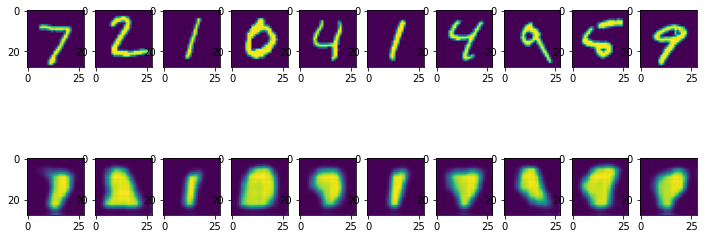

In [7]:
x_test_10 = x_test[:10]       # 테스트 데이터셋에서 10개만 골라서
x_test_hat = autoencoder.predict(x_test_10)    # AutoEncoder 모델의 이미지 복원생성
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(12,5))  # 이미지 사이즈 지정
for i in range(10):  
    # 원본이미지 출력
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # 생성된 이미지 출력
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_hat_imgs[i])

## Transposed Convolution

In [8]:
from tensorflow.python.keras.layers import Conv2DTranspose

# Conv2DTranspose를 활용한  AutoEncoder 모델
# AutoEncoder 모델 구성 - Input 부분
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder 모델 구성 - Encoder 부분
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu')
encode_pool_layer_1 = MaxPooling2D((2, 2))
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu')
encode_pool_layer_2 = MaxPooling2D((2, 2))
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)

# AutoEncoder 모델 구성 - Decoder 부분  - 
decode_conv_layer_1 = Conv2DTranspose(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2DTranspose(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   # Decoder는 Encoder의 출력을 입력으로 받습니다.
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

# AutoEncoder 모델 정의
autoencoder=Model(input_img, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 4)           292       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 3, 3, 4)           148 

In [9]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=300,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/300
235/235 [==============================] - 51s 215ms/step - loss: 0.6959 - val_loss: 0.6954
Epoch 2/300
235/235 [==============================] - 1s 5ms/step - loss: 0.6949 - val_loss: 0.6943
Epoch 3/300
235/235 [==============================] - 1s 5ms/step - loss: 0.6938 - val_loss: 0.6932
Epoch 4/300
235/235 [==============================] - 1s 5ms/step - loss: 0.6926 - val_loss: 0.6921
Epoch 5/300
235/235 [==============================] - 1s 5ms/step - loss: 0.6915 - val_loss: 0.6909
Epoch 6/300
235/235 [==============================] - 1s 5ms/step - loss: 0.6902 - val_loss: 0.6896
Epoch 7/300
235/235 [==============================] - 1s 5ms/step - loss: 0.6889 - val_loss: 0.6882
Epoch 8/300
235/235 [==============================] - 1s 5ms/step - loss: 0.6873 - val_loss: 0.6864
Epoch 9/300
235/235 [==============================] - 1s 5ms/step - loss: 0.6852 - val_loss: 0.6840
Epoch 10/300
235/235 [==============================] - 1s 5ms/step - loss: 0.6822 - val

235/235 [==============================] - 1s 5ms/step - loss: 0.2776 - val_loss: 0.2773
Epoch 82/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2771 - val_loss: 0.2768
Epoch 83/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2766 - val_loss: 0.2764
Epoch 84/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2761 - val_loss: 0.2759
Epoch 85/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2757 - val_loss: 0.2754
Epoch 86/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2752 - val_loss: 0.2750
Epoch 87/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2748 - val_loss: 0.2746
Epoch 88/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2743 - val_loss: 0.2741
Epoch 89/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2739 - val_loss: 0.2737
Epoch 90/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2735 - val_loss: 

Epoch 161/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2548 - val_loss: 0.2544
Epoch 162/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2545 - val_loss: 0.2542
Epoch 163/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2543 - val_loss: 0.2540
Epoch 164/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2541 - val_loss: 0.2538
Epoch 165/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2539 - val_loss: 0.2536
Epoch 166/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2537 - val_loss: 0.2534
Epoch 167/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2535 - val_loss: 0.2532
Epoch 168/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2533 - val_loss: 0.2529
Epoch 169/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2531 - val_loss: 0.2527
Epoch 170/300
235/235 [==============================] - 1s 5ms/step - lo

235/235 [==============================] - 1s 5ms/step - loss: 0.2398 - val_loss: 0.2394
Epoch 241/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2397 - val_loss: 0.2392
Epoch 242/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2395 - val_loss: 0.2390
Epoch 243/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2393 - val_loss: 0.2388
Epoch 244/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2392 - val_loss: 0.2387
Epoch 245/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2390 - val_loss: 0.2385
Epoch 246/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2389 - val_loss: 0.2383
Epoch 247/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2387 - val_loss: 0.2382
Epoch 248/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2385 - val_loss: 0.2380
Epoch 249/300
235/235 [==============================] - 1s 5ms/step - loss: 0.2384 - v

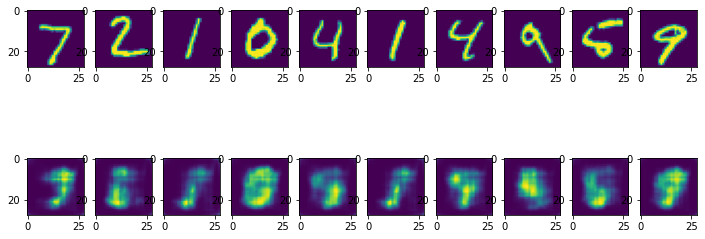

In [10]:
x_test_10 = x_test[:10]       # 테스트 데이터셋에서 10개만 골라서
x_test_hat = autoencoder.predict(x_test_10)    # AutoEncoder 모델의 이미지 복원생성
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(12,5))  # 이미지 사이즈 지정
for i in range(10):  
    # 원본이미지 출력
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # 생성된 이미지 출력
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_hat_imgs[i])